# Overview
The notebook shows how to extract the segmentation map for the ships, augment the images and train a simple DNN model to detect them. A few additional tweaks like balancing the ship-count out a little better have been done.

## Model Parameters
We might want to adjust these later (or do some hyperparameter optimizations)

In [1]:
BATCH_SIZE = 8
EDGE_CROP = 16
NB_EPOCHS = 30
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 400
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False

In [2]:
FLAG_PLOT = False

## Import logging

In [3]:
import logging
import sys
logger = logging.getLogger()
logger.handlers = []

# Set level
logger.setLevel(logging.INFO)
#logger.setLevel(logging.DEBUG)

# Create formatter
FORMAT = "%(levelno)-2s %(asctime)s : %(message)s"
DATE_FMT = "%Y-%m-%d %H:%M:%S"
formatter = logging.Formatter(FORMAT, DATE_FMT)

# Create handler and assign
handler = logging.StreamHandler(sys.stderr)
handler.setFormatter(formatter)
logger.handlers = [handler]
logging.info("Logging started")

20 2019-07-27 14:54:24 : Logging started


## Imports

In [4]:
import os
import logging
from pathlib import Path

# Sci stack
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# scikit-learn
from skimage.io import imread
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.morphology import label
from sklearn.model_selection import train_test_split
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)


# TensorFlow
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

# ship_dir = '../input'
# train_image_dir = os.path.join(ship_dir, 'train_v2')
# test_image_dir = os.path.join(ship_dir, 'test_v2')
import gc; gc.enable() # memory is tight


## Functions

In [5]:
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

## Set memory limit of TF

In [6]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 1
session = tf.Session(config=config)
import tensorflow.keras.backend as K
K.set_session(session=session)

In [8]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9266147303871762699, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14548421494380153483
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7589507541014127374
 physical_device_desc: "device: XLA_GPU device"]

## File Paths

In [12]:
DIR_INPUT = Path(r"~/DATA").expanduser()
assert DIR_INPUT.exists()
PATH_CSV = DIR_INPUT / 'train_ship_segmentations_v2.csv'
assert PATH_CSV.exists()
DIR_IMAGES = DIR_INPUT / 'images'
assert DIR_IMAGES.exists()
masks = pd.read_csv(PATH_CSV)
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
DIR_WEIGHTS = DIR_INPUT / 'weights'

231723 masks found
192556


In [13]:
masks
DIR_IMAGES.joinpath('teas').exists()
masks['exists'] = masks['ImageId'].apply(lambda image_id: DIR_IMAGES.joinpath(image_id).exists())
# r = masks.head(10)
masks = masks[masks['exists']]
logging.info("Resampled df to match existing images, {} records".format(len(masks)))

20 2019-07-27 14:56:33 : Resampled df to match existing images, 231723 records


# Make sure encode/decode works
Given the process
$$  RLE_0 \stackrel{Decode}{\longrightarrow} \textrm{Image}_0 \stackrel{Encode}{\longrightarrow} RLE_1 \stackrel{Decode}{\longrightarrow} \textrm{Image}_1 $$
We want to check if/that
$ \textrm{Image}_0 \stackrel{?}{=} \textrm{Image}_1 $
We could check the RLEs as well but that is more tedious. Also depending on how the objects have been labeled we might have different counts.



In [14]:
if FLAG_PLOT:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
    rle_0 = masks.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
    img_0 = masks_as_image(rle_0)
    ax1.imshow(img_0[:, :, 0])
    ax1.set_title('Image$_0$')
    rle_1 = multi_rle_encode(img_0)
    img_1 = masks_as_image(rle_1)
    ax2.imshow(img_1[:, :, 0])
    ax2.set_title('Image$_1$')
    print('Check Decoding->Encoding',
          'RLE_0:', len(rle_0), '->',
          'RLE_1:', len(rle_1))
    plt.show()

# Split into training and validation groups
We stratify by the number of boats appearing so we have nice balances in each set

20 2019-07-27 14:56:40 : Unique records: 191289
20 2019-07-27 14:56:40 : Total records: 231723


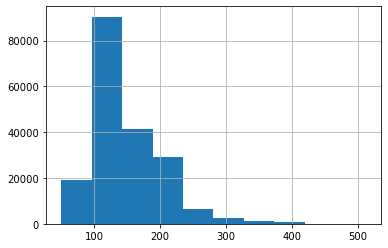

In [15]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
masks['ImageId'].apply(lambda image_id: DIR_IMAGES.joinpath(image_id).exists())

unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda image_id: os.stat(str(DIR_IMAGES.joinpath(image_id))).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb']>50] # keep only 50kb files
unique_img_ids['file_size_kb'].hist()
# plt.show()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(5)
logging.info("Unique records: {}".format(len(unique_img_ids)))
logging.info("Total records: {}".format(len(masks)))

In [16]:
train_ids, valid_ids = train_test_split(unique_img_ids,
                 test_size = 0.3, 
                 stratify = unique_img_ids['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

161048 training masks
69034 validation masks


### Examine Number of Ship Images
Here we examine how often ships appear and replace the ones without any ships with 0

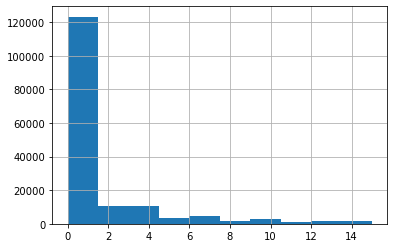

In [17]:
train_df['ships'].hist()
# plt.show()

# Undersample Empty Images
Here we undersample the empty images to get a better balanced group with more ships to try and segment

20 2019-07-27 14:56:44 : Balanced data frame with 11000 records


0     500
1     953
2     547
3     876
4     624
5     822
6     678
7     772
8     728
9     849
10    651
11    775
12    725
13    470
14    536
15    494
Name: ships, dtype: int64

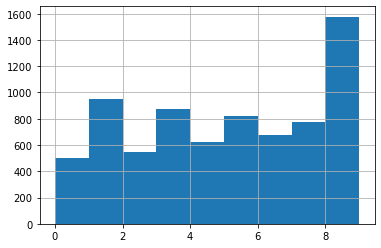

In [18]:
train_df['grouped_ship_count'] = train_df['ships'].map(lambda x: (x+1)//2).clip(0, 7)
def sample_ships(in_df, base_rep_val=1500):
    if in_df['ships'].values[0]==0:
        return in_df.sample(base_rep_val//3) # even more strongly undersample no ships
    else:
        return in_df.sample(base_rep_val, replace=(in_df.shape[0]<base_rep_val))

balanced_train_df = train_df.groupby('grouped_ship_count').apply(sample_ships)
balanced_train_df['ships'].hist(bins=np.arange(10))
logging.info("Balanced data frame with {} records".format(len(balanced_train_df)))
# plt.show()
balanced_train_df['ships'].value_counts().sort_index()

# Decode all the RLEs into Images
We make a generator to produce batches of images

In [19]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = DIR_IMAGES / c_img_id
            c_img = imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

In [20]:
train_gen = make_image_gen(balanced_train_df)
# Get a single sample
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (8, 768, 768, 3) 0.0 1.0
y (8, 768, 768, 1) 0 1


In [21]:
if FLAG_PLOT:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
    batch_rgb = montage_rgb(train_x)
    batch_seg = montage(train_y[:, :, :, 0])
    ax1.imshow(batch_rgb)
    ax1.set_title('Images')
    ax2.imshow(batch_seg)
    ax2.set_title('Segmentations')
    ax3.imshow(mark_boundaries(batch_rgb, 
                               batch_seg.astype(int)))
    ax3.set_title('Outlined Ships')
    plt.show()
    # fig.savefig('overview.png')

# Make the Validation Set

In [22]:
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

(400, 768, 768, 3) (400, 768, 768, 1)


# Augment Data

In [23]:
dg_args = dict(featurewise_center = False,
                  samplewise_center = False,
                  rotation_range = 15, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')
# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

In [24]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]


x (8, 768, 768, 3) float32 0.0 1.0
y (8, 768, 768, 1) float32 0.0 1.0


In [25]:
if FLAG_PLOT:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
    ax1.imshow(montage_rgb(t_x), cmap='gray')
    ax1.set_title('images')
    ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
    ax2.set_title('ships')
    plt.show()

In [26]:
gc.collect()

27

# Build a Model
Here we use a slight deviation on the U-Net standard

In [27]:
# Build U-Net model
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)

def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img
if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model = models.Model(inputs=[input_img], outputs=[d])
seg_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 768, 768, 3)  0           RGB_Input[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 768, 768, 3)  12          gaussian_noise[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 768, 768, 8)  224         batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

In [28]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [29]:
weight_path = DIR_WEIGHTS / "{}_weights.best.hdf5".format('seg_model')
weight_path = str(weight_path)
checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

30 2019-07-27 14:57:48 : `epsilon` argument is deprecated and will be removed, use `min_delta` instead.


In [30]:
print('Potential step size:', balanced_train_df.shape[0]//BATCH_SIZE)
step_count = min(MAX_TRAIN_STEPS, balanced_train_df.shape[0]//BATCH_SIZE)
print('Actual steps per epoch:', step_count)

Potential step size: 1375
Actual steps per epoch: 200


## FIT THE MODEL

In [ ]:
aug_gen = create_aug_gen(make_image_gen(balanced_train_df))
loss_history = [seg_model.fit_generator(aug_gen, 
                             steps_per_epoch=step_count, 
                             epochs=NB_EPOCHS, 
                             validation_data=(valid_x, valid_y),
                             callbacks=callbacks_list,
                            workers=1 # the generator is not very thread safe
                                       )]

Epoch 1/30
199/200 [============================>.] - ETA: 16s - loss: -0.1682 - dice_coef: 0.0226 - binary_accuracy: 0.5460 - true_positive_rate: 0.7152

30 2019-07-27 15:56:54 : This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x7fc3ebfb5da0>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.



Epoch 00001: val_dice_coef improved from -inf to 0.29849, saving model to /home/ubuntu/DATA/weights/seg_model_weights.best.hdf5
200/200 [==============================] - 3539s 18s/step - loss: -0.1726 - dice_coef: 0.0232 - binary_accuracy: 0.5483 - true_positive_rate: 0.7117 - val_loss: -2.3877 - val_dice_coef: 0.2985 - val_binary_accuracy: 0.9988 - val_true_positive_rate: nan
Epoch 2/30
199/200 [============================>.] - ETA: 16s - loss: -0.9954 - dice_coef: 0.1244 - binary_accuracy: 0.9968 - true_positive_rate: 0.0000e+00

30 2019-07-27 16:55:37 : This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x7fc3ebfb5da0>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.



Epoch 00002: val_dice_coef improved from 0.29849 to 0.66950, saving model to /home/ubuntu/DATA/weights/seg_model_weights.best.hdf5
200/200 [==============================] - 3523s 18s/step - loss: -0.9905 - dice_coef: 0.1238 - binary_accuracy: 0.9968 - true_positive_rate: 0.0000e+00 - val_loss: -5.3548 - val_dice_coef: 0.6695 - val_binary_accuracy: 0.9988 - val_true_positive_rate: nan
Epoch 3/30
 76/200 [==========>...................] - ETA: 33:16 - loss: -0.8022 - dice_coef: 0.1003 - binary_accuracy: 0.9967 - true_positive_rate: 0.0000e+00

In [ ]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_history)
plt.show()

## Save weights

In [ ]:
seg_model.load_weights(weight_path)
seg_model.save('seg_model.h5')

In [27]:
seg_model.load_weights(weight_path)

In [28]:
pred_y = seg_model.predict(valid_x, batch_size=4)
print(pred_y.shape, pred_y.min(), pred_y.max(), pred_y.mean())

(400, 768, 768, 1) 0.0 0.0023689687 2.5622537e-08


In [ ]:
pred_y[50,:,:,0]
pred_y[50,:,:,:].shape
probs = pred_y[50,:,:,0].ravel()
plt.hist(probs[probs > 0.1])
#plt.hist(probs[probs > 0.1])
plt.hist()
pred_y[50,0,1]
for i in range(10):
    plt.imshow(pred_y[i,:,:,0])
    plt.show()

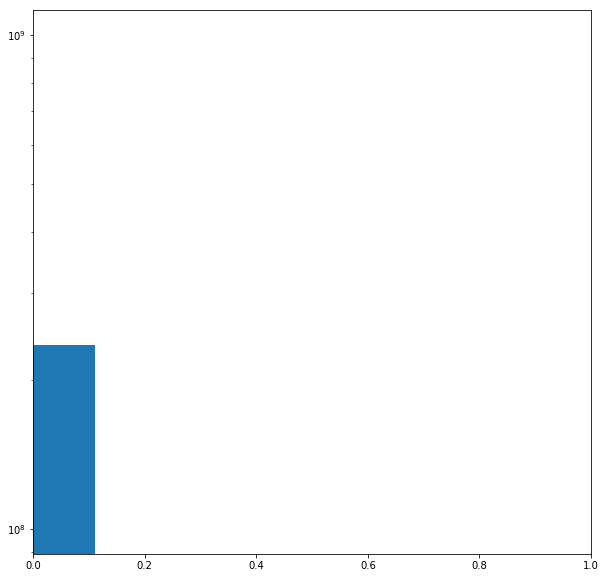

In [29]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 10))
ax.set_xlim(0, 1)
ax.set_yscale('log', nonposy='clip')


# Prepare Full Resolution Model
Here we account for the scaling so everything can happen in the model itself

In [ ]:
if IMG_SCALING is not None:
    fullres_model = models.Sequential()
    fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    fullres_model.add(seg_model)
    fullres_model.add(layers.UpSampling2D(IMG_SCALING))
else:
    fullres_model = seg_model
fullres_model.save('fullres_model.h5')

# Run the test data

In [ ]:
test_paths = os.listdir(test_image_dir)
print(len(test_paths), 'test images found')

In [ ]:
fig, m_axs = plt.subplots(20, 2, figsize = (10, 40))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2), c_img_name in zip(m_axs, test_paths):
    c_path = os.path.join(test_image_dir, c_img_name)
    c_img = imread(c_path)
    first_img = np.expand_dims(c_img, 0)/255.0
    first_seg = fullres_model.predict(first_img)
    ax1.imshow(first_img[0])
    ax1.set_title('Image')
    ax2.imshow(first_seg[0, :, :, 0], vmin = 0, vmax = 1)
    ax2.set_title('Prediction')
fig.savefig('test_predictions.png')

# Submission
Since gneerating the submission takes a long time and quite a bit of memory we run it in a seperate kernel located at https://www.kaggle.com/kmader/from-trained-u-net-to-submission-part-2 
That kernel takes the model saved in this kernel and applies it to all the test data